## Clustering with Categorical Features using DBSCAN

This notebook clusters articles using categorical features and DBSCAN, leveraging `hnm_data_analysis/clustering/article_clustering.py`. We encode categoricals, reduce dimensionality, scale features, then visualise and interpret the resulting clusters.


In [1]:
# Ensure project root is the working directory so relative paths resolve
import os
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
print('CWD:', os.getcwd())

CWD: /Users/tom/Data Analysis Projects/h_and_m_data_analysis


In [2]:
import polars as pl
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, Normalizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import joblib
from pathlib import Path

# Import the ArticleClusterer module
from hnm_data_analysis.clustering.article_clustering import ArticleClusterer, ClusteringConfig

In [3]:
# Load the final dataset
data_path = 'data/features/final/articles_features_final.parquet'
df = pl.read_parquet(data_path)
print(f'Loaded data: {df.shape[0]:,} rows x {df.shape[1]} columns')
print(f'Columns: {df.columns}')

Loaded data: 42,298 rows x 14 columns
Columns: ['article_id', 'product_type_name', 'product_group_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name', 'detail_desc', 'bert_cluster']


In [4]:
# Select categorical features for clustering (filter by dtype), excluding specified columns
exclude_cols = [
    'article_id', 'bert_cluster', 'perceived_colour_master_name',
    'index_name', 'index_group_name', 'detail_desc'
]

# Identify categorical/text columns from Polars dtypes
# Use isinstance to check for Categorical type more reliably
cat_candidates = []
for col, dtype in zip(df.columns, df.dtypes):
    if isinstance(dtype, pl.Categorical) or dtype == pl.Utf8 or dtype == pl.Boolean:
        cat_candidates.append(col)

# Keep only categorical columns not in the exclude list
feature_cols = [c for c in cat_candidates if c not in exclude_cols]

# Fallback: include low-cardinality integer columns as categoricals if nothing selected
if len(feature_cols) == 0:
    int_types = {pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64}
    # Compute n_unique per integer column (excluding excluded)
    int_cols = [c for c, dt in zip(df.columns, df.dtypes) if dt in int_types and c not in exclude_cols]
    if int_cols:
        nunique_df = df.select([pl.col(c).n_unique().alias(c) for c in int_cols])
        nunique = {c: int(nunique_df[c][0]) for c in int_cols}
        # Treat as categorical if unique count <= 100
        feature_cols = [c for c in int_cols if nunique[c] <= 100]

print(f'Total articles for clustering: {df.shape[0]:,}')
print(f'Excluded columns: {exclude_cols}')
print(f'Categorical candidates ({len(cat_candidates)}): {cat_candidates}')
print(f'Using categorical feature columns ({len(feature_cols)}): {feature_cols}')

Total articles for clustering: 42,298
Excluded columns: ['article_id', 'bert_cluster', 'perceived_colour_master_name', 'index_name', 'index_group_name', 'detail_desc']
Categorical candidates (12): ['product_type_name', 'product_group_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name', 'detail_desc']
Using categorical feature columns (8): ['product_type_name', 'product_group_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'department_name', 'section_name', 'garment_group_name']


In [5]:
# Convert to pandas for sklearn compatibility (using all articles)
df_features = df.select(feature_cols).to_pandas()
article_ids = df.select('article_id').to_pandas()['article_id'].values

print(f'Feature matrix shape: {df_features.shape}')
print(f'Article IDs: {len(article_ids)}')
print(f'\nFeature data types:')
print(df_features.dtypes)

Feature matrix shape: (42298, 8)
Article IDs: 42298

Feature data types:
product_type_name              category
product_group_name             category
graphical_appearance_name      category
colour_group_name              category
perceived_colour_value_name    category
department_name                category
section_name                   category
garment_group_name             category
dtype: object


In [6]:
# Preprocess categorical features (all columns are categorical now)

# All feature columns are categorical (the dataset now only contains categorical columns)
categorical_cols = feature_cols
print(f'Categorical columns ({len(categorical_cols)}): {categorical_cols}')

# Create sparse one-hot encoder for categorical features (memory-efficient)
# Keep full basis (no drop) for clustering
encoder = OneHotEncoder(drop=None, sparse=True, handle_unknown='ignore')

# Fit and transform the features to a sparse matrix
if len(feature_cols) == 0:
    raise ValueError("No categorical features available after exclusions. Please adjust 'exclude_cols' or dtype filters.")
X_ohe = encoder.fit_transform(df_features[feature_cols])
print(f'\nProcessed sparse OHE matrix shape: {X_ohe.shape} (nnz={X_ohe.nnz:,})')

Categorical columns (8): ['product_type_name', 'product_group_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'department_name', 'section_name', 'garment_group_name']

Processed sparse OHE matrix shape: (42298, 545) (nnz=338,384)


/Users/tom/Data Analysis Projects/h_and_m_data_analysis/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
# Save processed categorical features for ArticleClusterer
# Apply TruncatedSVD for dimensionality reduction on sparse OHE, then L2-normalise rows for cosine DBSCAN
if X_ohe.shape[1] < 2:
    raise ValueError(f"OHE produced only {X_ohe.shape[1]} feature(s). Check selected categorical columns: {feature_cols}")
# Keep components <= n_features-1 to satisfy SVD requirements
n_components = min(50, X_ohe.shape[1] - 1)
svd = TruncatedSVD(n_components=n_components, random_state=42)
X_svd = svd.fit_transform(X_ohe)

# Row-wise L2 normalisation helps cosine/Euclidean behave better in moderate dims
normalizer = Normalizer(norm='l2')
X_scaled = normalizer.fit_transform(X_svd)

print(f'SVD reduced features to {X_svd.shape[1]} components')
print(f'Explained variance ratio (first 10): {svd.explained_variance_ratio_[:10]}')
print(f'Total explained variance: {svd.explained_variance_ratio_.sum():.3f}')
print(f'Normalised feature matrix shape: {X_scaled.shape}')

# Create categorical features dataset compatible with ArticleClusterer
categorical_features_dir = Path('data/features/categorical')
categorical_features_dir.mkdir(parents=True, exist_ok=True)

# Save scaled SVD features as parquet with article_id and feature columns
feature_column_names = [f'svd_{i:03d}' for i in range(X_scaled.shape[1])]
categorical_features_df = pl.DataFrame({
    'article_id': article_ids,
    **{name: X_scaled[:, i] for i, name in enumerate(feature_column_names)}
})

categorical_features_path = categorical_features_dir / 'svd_categorical_features.parquet'
categorical_features_df.write_parquet(categorical_features_path)
print(f'Saved categorical features to: {categorical_features_path}')

SVD reduced features to 50 components
Explained variance ratio (first 10): [0.02583921 0.06567456 0.04837291 0.04839004 0.0444697  0.03313846
 0.03087598 0.02825961 0.02614194 0.02310391]
Total explained variance: 0.717
Normalised feature matrix shape: (42298, 50)
Saved categorical features to: data/features/categorical/svd_categorical_features.parquet


In [8]:
# Initialise ArticleClusterer with categorical features
clusterer = ArticleClusterer(
    features_path=str(categorical_features_path),
    articles_metadata_path='data/features/final/articles_features_final.parquet'
)

# Load features and metadata
clusterer.load_features()
clusterer.load_articles_metadata()

Loaded features: 42,298 articles x 50 features
Loaded articles metadata: 42,298 articles


article_id,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,bert_cluster
i64,cat,cat,cat,cat,cat,cat,cat,cat,cat,cat,cat,cat,i64
652356082,"""Underwear bottom""","""Underwear""","""All over pattern""","""Orange""","""Dusty Light""","""Orange""","""Underwear Woven""","""Menswear""","""Menswear""","""Men Underwear""","""Under-, Nightwear""","""Boxer shorts in a cotton weave…",10
212629004,"""Dress""","""Garment Full body""","""Solid""","""Black""","""Dark""","""Black""","""Basic 1""","""Divided""","""Divided""","""Divided Basics""","""Jersey Basic""","""Long, sleeveless dress in jers…",28
619601011,"""Robe""","""Underwear""","""Mixed solid/pattern""","""Light Yellow""","""Light""","""Yellow""","""Kids Girl UW/NW""","""Children Sizes 92-140""","""Baby/Children""","""Girls Underwear & Basics""","""Under-, Nightwear""","""Dressing gown in terry with a …",29
680846003,"""Blouse""","""Garment Upper body""","""Solid""","""Light Pink""","""Dusty Light""","""Pink""","""Campaigns""","""Ladieswear""","""Ladieswear""","""Womens Everyday Collection""","""Special Offers""","""Blouse in airy crêpe with a sm…",14
777020002,"""Shorts""","""Garment Lower body""","""Solid""","""Light Turquoise""","""Light""","""Turquoise""","""Trousers & Skirt""","""Ladieswear""","""Ladieswear""","""Womens Trend""","""Trousers""","""Shorts in an airy, crinkled ny…",18
…,…,…,…,…,…,…,…,…,…,…,…,…,…
428291007,"""Hat/beanie""","""Accessories""","""Solid""","""Grey""","""Dusty Light""","""Grey""","""Knit & Woven""","""Divided""","""Divided""","""Divided Accessories""","""Accessories""","""Knitted headband containing so…",29
796671002,"""Trousers""","""Garment Lower body""","""All over pattern""","""Dark Blue""","""Dark""","""Blue""","""Kids Girl Trouser""","""Children Sizes 92-140""","""Baby/Children""","""Kids Girl""","""Trousers""","""Treggings in patterned stretch…",24
814594005,"""T-shirt""","""Garment Upper body""","""Front print""","""White""","""Light""","""White""","""Young Boy Jersey Fancy""","""Children Sizes 134-170""","""Baby/Children""","""Young Boy""","""Jersey Fancy""","""Classic T-shirt in soft cotton…",23


In [9]:
# Create output directory
out_dir = Path('results/categorical_clustering')
out_dir.mkdir(parents=True, exist_ok=True)

We use DBSCAN (density-based clustering), which does not require a pre-set number of clusters. We now:

- Encode categoricals sparsely and reduce with TruncatedSVD, then scale.
- Choose `eps` via a k-distance curve heuristic and sweep multiple metrics (`euclidean`, `cosine`) and `min_samples`.
- Run DBSCAN with the `ArticleClusterer`, evaluate on non-noise points, and save artefacts.


Saved k-distance plot to: results/categorical_clustering/kdist_metric_cosine_k_15.png


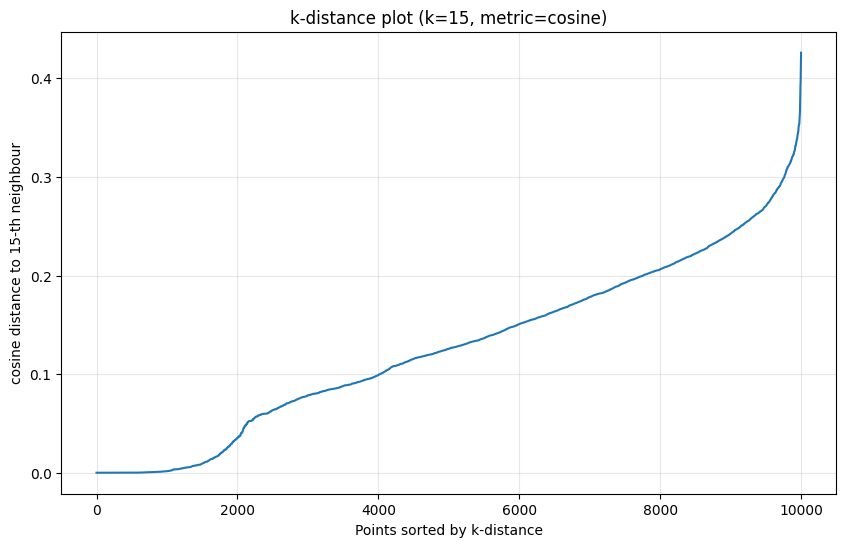

Saved k-distance plot to: results/categorical_clustering/kdist_metric_cosine_k_30.png


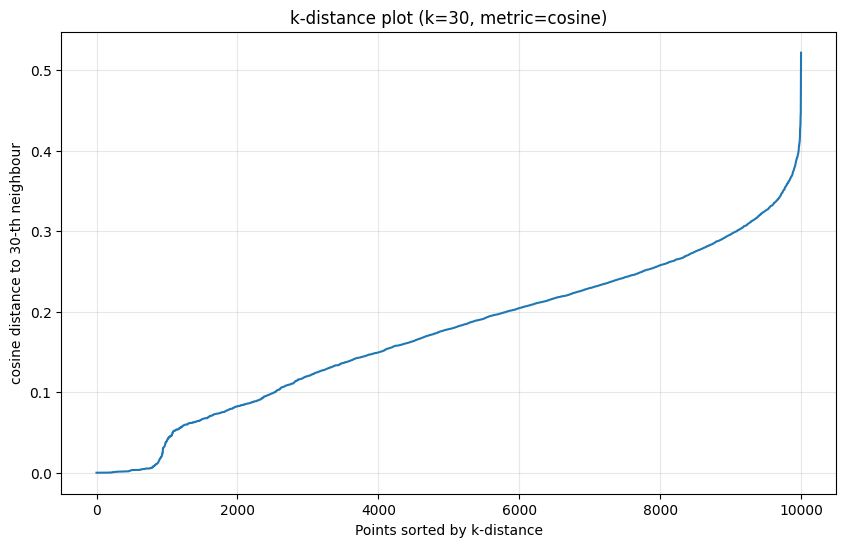

Saved k-distance plot to: results/categorical_clustering/kdist_metric_cosine_k_60.png


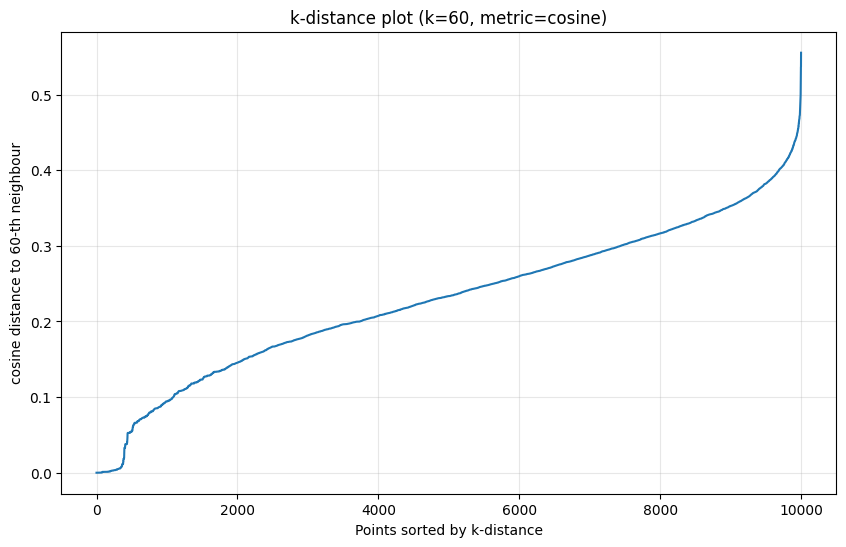

Saved k-distance plot to: results/categorical_clustering/kdist_metric_euclidean_k_15.png


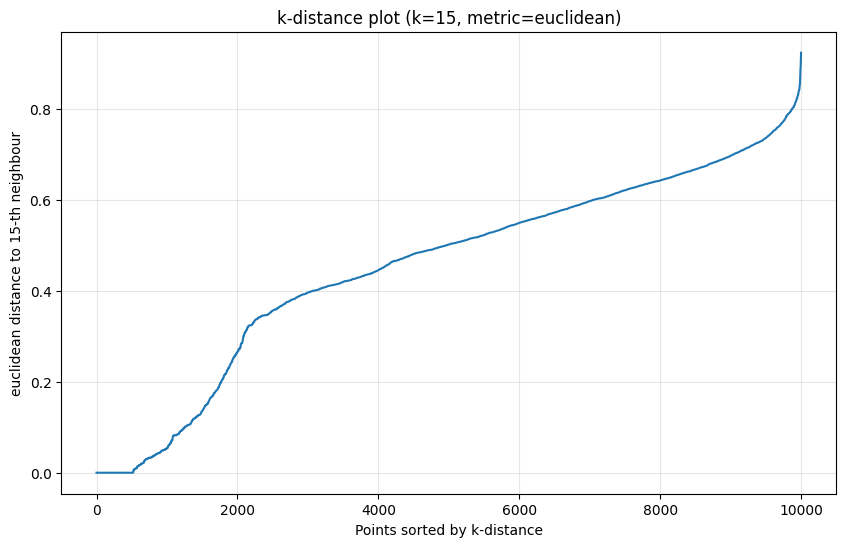

Saved k-distance plot to: results/categorical_clustering/kdist_metric_euclidean_k_30.png


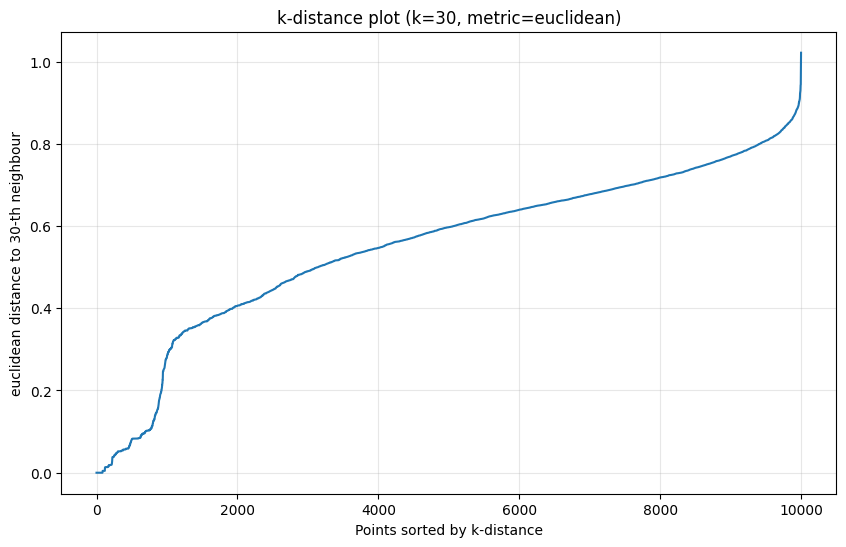

Saved k-distance plot to: results/categorical_clustering/kdist_metric_euclidean_k_60.png


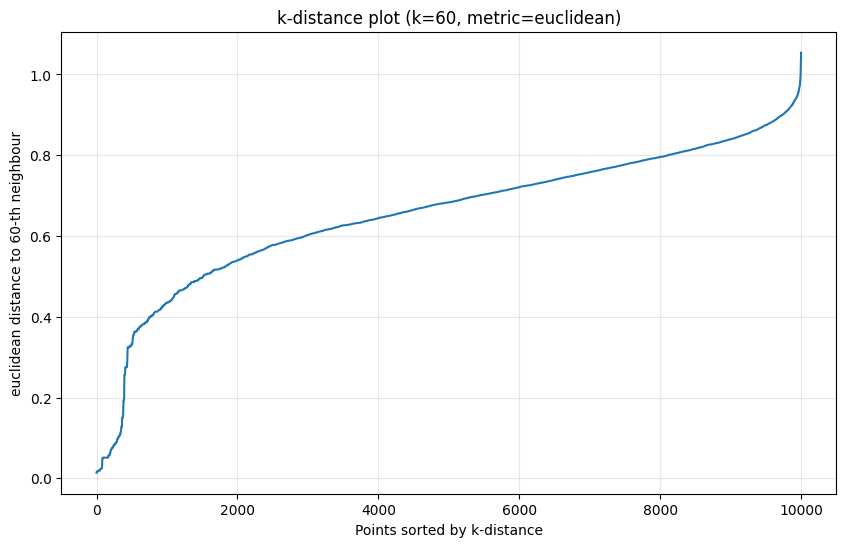

Performing dbscan clustering...
DBSCAN found 328 clusters and 31287 noise points
Clustering completed: 328 clusters
Silhouette Score: 0.8945
Calinski-Harabasz Index: 84597.0117
Davies-Bouldin Index: 0.1275
Tried metric=cosine, eps=0.0010, min_samples=15 -> clusters=328, noise=74.0%, largest_cluster=3.8%, silhouette=0.8944981098175049
Performing dbscan clustering...
DBSCAN found 328 clusters and 31287 noise points
Clustering completed: 328 clusters
Silhouette Score: 0.8945
Calinski-Harabasz Index: 84597.0117
Davies-Bouldin Index: 0.1275
Tried metric=cosine, eps=0.0010, min_samples=15 -> clusters=328, noise=74.0%, largest_cluster=3.8%, silhouette=0.8944981098175049
Performing dbscan clustering...
DBSCAN found 375 clusters and 27442 noise points
Clustering completed: 375 clusters
Silhouette Score: 0.8526
Calinski-Harabasz Index: 10989.9676
Davies-Bouldin Index: 0.2237
Tried metric=cosine, eps=0.0056, min_samples=15 -> clusters=375, noise=64.9%, largest_cluster=4.2%, silhouette=0.852588653

In [10]:
# DBSCAN parameter sweep with metric options and k-distance heuristic

# Prefer cosine in L2-normalised SVD space; also try euclidean as fallback
metrics_to_try = ['cosine', 'euclidean']
min_samples_grid = [15, 30, 60]

# Optionally suggest eps via k-distance elbow per metric/min_samples
kdist_samples = 10000 if clusterer.features.shape[0] > 10000 else None

candidates = []
for metric in metrics_to_try:
    for ms in min_samples_grid:
        kdist = clusterer.plot_k_distance(k=ms, metric=metric, sample_size=kdist_samples,
                                          save_path=str(out_dir / f'kdist_metric_{metric}_k_{ms}.png'))
        # Ignore exact-zero distances (duplicates or identical neighbours)
        kdist_pos = kdist[kdist > 0]
        if kdist_pos.size == 0:
            kdist_pos = kdist
        # Use lower quantiles for eps proposals to avoid over-merging in high/moderate dims
        for q in [0.02, 0.05, 0.10, 0.15]:
            raw_eps = float(np.quantile(kdist_pos, q))
            min_eps = 1e-3 if metric == 'cosine' else 1e-6
            eps = max(raw_eps, min_eps)
            candidates.append((metric, ms, eps))

best_score = -np.inf
best_params = None

for metric, ms, eps in candidates:
    cfg_try = ClusteringConfig(algorithm='dbscan', dbscan_eps=eps, dbscan_min_samples=ms, dbscan_metric=metric)
    res_try = clusterer.cluster(cfg_try)
    score = res_try.silhouette if res_try.silhouette is not None else -np.inf
    # Consider configs that yield at least 2 clusters, <60% noise, and avoid a dominant mega-cluster
    noise_rate = (res_try.labels == -1).sum() / len(res_try.labels)
    labels_no_noise = res_try.labels[res_try.labels != -1]
    if labels_no_noise.size > 0:
        uniq, cnts = np.unique(labels_no_noise, return_counts=True)
        largest_share = cnts.max() / labels_no_noise.size
    else:
        largest_share = 1.0
    if res_try.n_clusters >= 2 and noise_rate < 0.6 and largest_share < 0.7 and score > best_score:
        best_score = score
        best_params = (metric, ms, eps)
    print(f"Tried metric={metric}, eps={eps:.4f}, min_samples={ms} -> clusters={res_try.n_clusters}, noise={noise_rate:.1%}, largest_cluster={largest_share:.1%}, silhouette={res_try.silhouette}")

# Fallback if no valid configuration found - use conservative eps on cosine
if best_params is None:
    print("No valid DBSCAN config found with >=2 clusters; falling back to conservative eps")
    metric = 'cosine'
    ms = 30
    kdist = clusterer.compute_k_distances(k=ms, metric=metric, sample_size=kdist_samples)
    kdist_pos = kdist[kdist > 0]
    if kdist_pos.size == 0:
        kdist_pos = kdist
    raw_eps = float(np.quantile(kdist_pos, 0.05))
    eps = max(raw_eps, 1e-3)
    best_params = (metric, ms, eps)

# Ensure clusterer holds best model/results for downstream visualisation/saving
config = ClusteringConfig(algorithm='dbscan', dbscan_eps=best_params[2], dbscan_min_samples=best_params[1], dbscan_metric=best_params[0])
results = clusterer.cluster(config)

print(f"\nSelected DBSCAN params: metric={best_params[0]}, eps={best_params[2]:.4f}, min_samples={best_params[1]}")
print('Final clustering results:')
print(f'Number of clusters (excl. noise): {results.n_clusters}')
print(f'Silhouette Score (non-noise): {results.silhouette}')
print(f'Calinski-Harabasz Index: {results.calinski_harabasz}')
print(f'Davies-Bouldin Index: {results.davies_bouldin}')

# Show cluster distribution (include noise as -1)
unique, counts = np.unique(results.labels, return_counts=True)
print('\nCluster distribution (including noise = -1):')
for cluster_id, count in zip(unique, counts):
    print(f'Cluster {cluster_id}: {count} items ({count/len(results.labels)*100:.1f}%)')

Creating 2D visualization using PCA...
Saved cluster visualization to: results/categorical_clustering/clusters_pca_dbscan.png


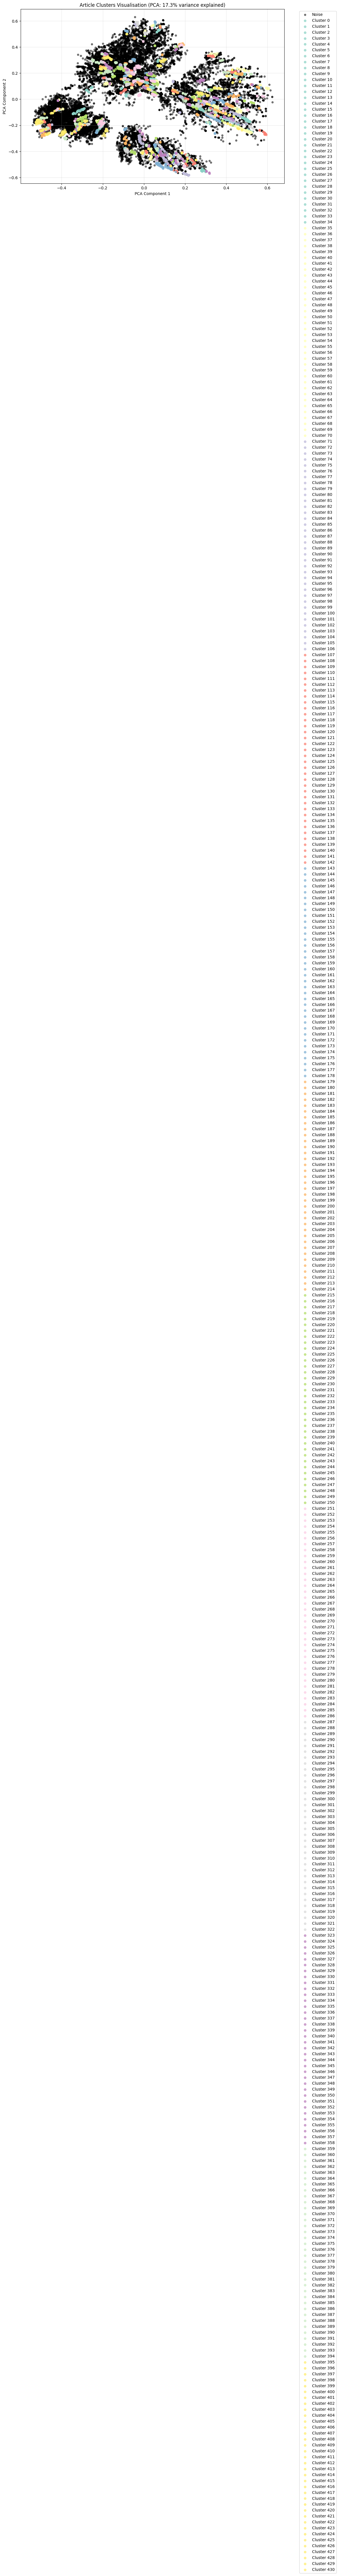

Creating 2D visualization using TSNE...
Saved cluster visualization to: results/categorical_clustering/clusters_tsne_dbscan.png


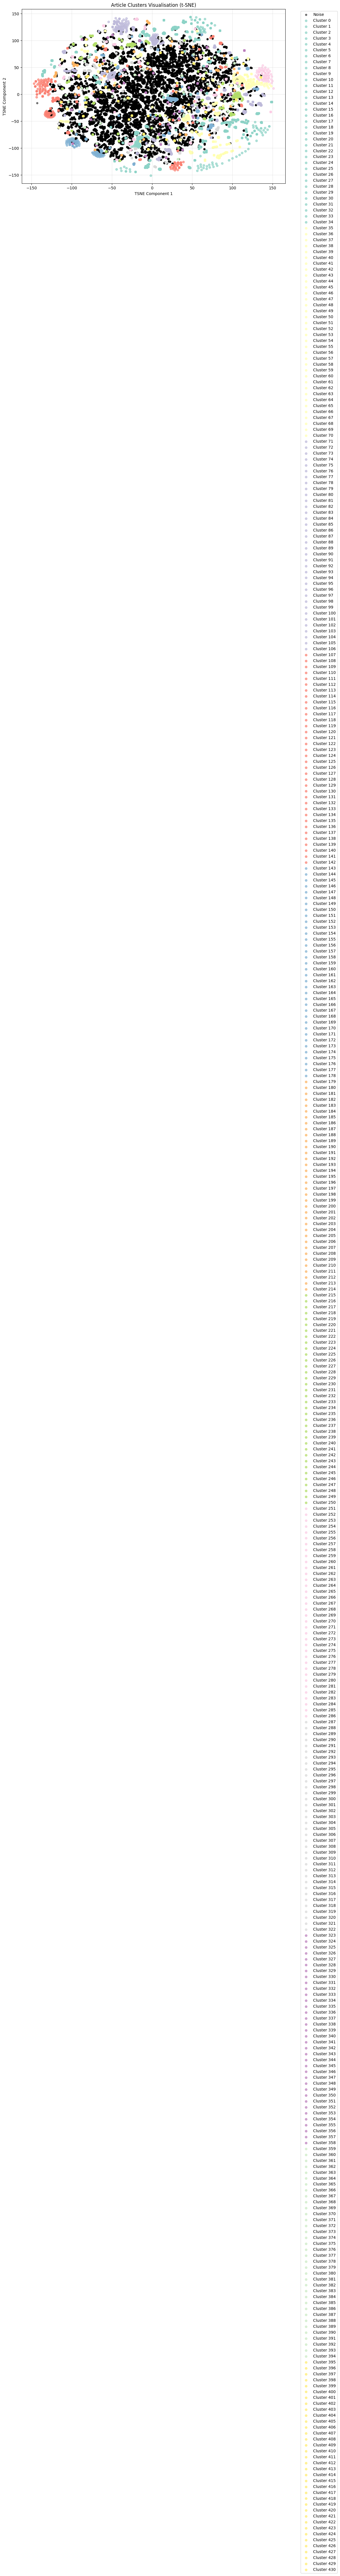

Noise rate: 59.1%


In [11]:
# Use ArticleClusterer's built-in visualisation methods
clusterer.visualise_clusters(method='pca', save_path=str(out_dir / 'clusters_pca_dbscan.png'))
clusterer.visualise_clusters(method='tsne', save_path=str(out_dir / 'clusters_tsne_dbscan.png'))

# Track and print noise rate
noise_fraction = (results.labels == -1).sum() / len(results.labels)
print(f"Noise rate: {noise_fraction:.1%}")

In [12]:
# Use ArticleClusterer's interpretation functionality
cluster_interpretations = clusterer.interpret_clusters()

# Display sample articles from different clusters
print('Sample cluster interpretations:')
for cluster_id in list(cluster_interpretations.keys())[:3]:  # Show first 3 clusters
    interpretation = cluster_interpretations[cluster_id]
    print(f'\nCluster {cluster_id}:')
    print(f'  Size: {interpretation["size"]} articles ({interpretation["percentage"]:.1f}%)')
    
    # Show top categories for this cluster
    for key, values in interpretation.items():
        if key.startswith('top_') and isinstance(values, dict):
            category_name = key.replace('top_', '').replace('_', ' ').title()
            print(f'  {category_name}: {dict(list(values.items())[:3])}')  # Show top 3 values

# Also display sample articles using the original function but with clusterer's data
def display_cluster_samples(clusterer_obj, labels, n_clusters_sample=3, n_articles_per_cluster=3):
    unique_clusters = np.unique(labels)
    unique_clusters = unique_clusters[unique_clusters != -1]  # exclude noise
    if len(unique_clusters) == 0:
        print('No non-noise clusters to sample from.')
        return
    sampled_clusters = np.random.choice(unique_clusters, 
                                      size=min(n_clusters_sample, len(unique_clusters)), 
                                      replace=False)
    
    print(f'\nDetailed samples from clusters: {sampled_clusters}')
    
    for cluster_id in sampled_clusters:
        cluster_indices = np.where(labels == cluster_id)[0]
        if len(cluster_indices) == 0:
            continue
            
        sample_indices = np.random.choice(cluster_indices, 
                                        size=min(n_articles_per_cluster, len(cluster_indices)), 
                                        replace=False)
        sampled_article_ids = [clusterer_obj.article_ids[i] for i in sample_indices]
        
        print(f'\nCluster {cluster_id} — {len(cluster_indices)} items; showing {len(sampled_article_ids)} samples')
        
        # Display sample articles from this cluster
        if clusterer_obj.articles_metadata is not None:
            sample_df = clusterer_obj.articles_metadata.filter(pl.col('article_id').is_in(sampled_article_ids))
            display_cols = ['article_id', 'product_group_name', 'product_type_name', 
                           'department_name', 'garment_group_name', 'colour_group_name',
                           'graphical_appearance_name', 'detail_desc', 'bert_cluster']
            
            # Only select columns that exist in the dataframe
            existing_cols = [col for col in display_cols if col in sample_df.columns]
            print(sample_df.select(existing_cols).to_pandas())

# Display sample clusters
display_cluster_samples(clusterer, results.labels)

Sample cluster interpretations:

Cluster 0:
  Size: 40 articles (0.1%)
  Product Group Name: {'Garment Full body': 40}
  Product Type Name: {'Dress': 40}
  Colour Group Name: {'Black': 40}
  Department Name: {'Basic 1': 40}
  Garment Group Name: {'Jersey Basic': 40}

Cluster 1:
  Size: 559 articles (1.3%)
  Product Group Name: {'Accessories': 559}
  Product Type Name: {'Earring': 286, 'Necklace': 133, 'Ring': 63}
  Colour Group Name: {'Gold': 513, 'Other Pink': 11, 'Red': 8}
  Department Name: {'Jewellery': 367, 'Jewellery Extended': 152, 'Hair Accessories': 23}
  Garment Group Name: {'Accessories': 559}

Cluster 2:
  Size: 17 articles (0.0%)
  Product Group Name: {'Garment Upper body': 17}
  Product Type Name: {'Sweater': 17}
  Colour Group Name: {'Black': 17}
  Department Name: {'Loungewear': 17}
  Garment Group Name: {'Under-, Nightwear': 17}

Detailed samples from clusters: [252  56 200]

Cluster 252 — 35 items; showing 3 samples
   article_id product_group_name product_type_name d

In [13]:
# Use ArticleClusterer's save functionality
clusterer.save_results(str(out_dir))

# Also save preprocessing artefacts for reproducibility
joblib.dump(encoder, out_dir / 'encoder.joblib')
print(f'Saved encoder to: {out_dir / "encoder.joblib"}')

joblib.dump(svd, out_dir / 'svd_model.joblib')
print(f'Saved SVD model to: {out_dir / "svd_model.joblib"}')

joblib.dump(normalizer, out_dir / 'normalizer.joblib')
print(f'Saved normaliser to: {out_dir / "normalizer.joblib"}')

# Save additional metadata about the categorical preprocessing and DBSCAN config
import json
preprocessing_metadata = {
    'preprocessing_method': 'sparse_one_hot_svd_row_l2',
    'n_features_original': int(X_ohe.shape[1]),
    'n_features_svd': int(X_svd.shape[1]),
    'n_articles': int(len(article_ids)),
    'explained_variance_ratio': float(svd.explained_variance_ratio_.sum()),
    'feature_columns_used': feature_cols,
    'categorical_columns': categorical_cols,
    'categorical_columns_used': feature_cols,
    'categorical_candidates': cat_candidates,
    'excluded_columns': exclude_cols,
    'categorical_features_file': str(categorical_features_path),
    'dbscan_params': {'metric': str(best_params[0]), 'eps': float(best_params[2]), 'min_samples': int(best_params[1])}
}

with open(out_dir / 'preprocessing_metadata.json', 'w') as f:
    json.dump(preprocessing_metadata, f, indent=2)
print(f'Saved preprocessing metadata to: {out_dir / "preprocessing_metadata.json"}')

Saved cluster labels to: results/categorical_clustering/cluster_labels.csv
Saved clustering model to: results/categorical_clustering/clustering_model.joblib
Saved results metadata to: results/categorical_clustering/clustering_results.json
Saved cluster interpretations to: results/categorical_clustering/cluster_interpretations.json
Saved encoder to: results/categorical_clustering/encoder.joblib
Saved SVD model to: results/categorical_clustering/svd_model.joblib
Saved normaliser to: results/categorical_clustering/normalizer.joblib
Saved preprocessing metadata to: results/categorical_clustering/preprocessing_metadata.json


In [14]:
# Create final dataset with both BERT and categorical clusters
print('Creating final dataset with categorical cluster labels...')

# Get categorical cluster labels from ArticleClusterer results
cat_labels_pl = pl.DataFrame({
    'article_id': clusterer.article_ids,
    'categorical_cluster': results.labels
})

# Join with original dataset (now includes ALL articles with categorical clusters)
final_dataset = df.join(cat_labels_pl, on='article_id', how='left')

print(f'Final dataset shape: {final_dataset.shape}')
print(f'Articles with categorical clusters: {final_dataset.filter(pl.col("categorical_cluster").is_not_null()).shape[0]:,}')
print(f'Articles with BERT clusters: {final_dataset.filter(pl.col("bert_cluster").is_not_null()).shape[0]:,}')

# Show overlap between clustering methods
both_clusters = final_dataset.filter(
    (pl.col("categorical_cluster").is_not_null()) & 
    (pl.col("bert_cluster").is_not_null())
).shape[0]
print(f'Articles with both cluster types: {both_clusters:,}')

# Save the enhanced dataset
output_path = Path('data/features/final/articles_features_with_clusters.parquet')
final_dataset.write_parquet(output_path)
print(f'Saved enhanced dataset to: {output_path}')

print(f'\nDataset summary:')
print('BERT clusters:', final_dataset.select('bert_cluster').filter(pl.col('bert_cluster').is_not_null()).shape[0])
print('Categorical clusters:', final_dataset.select('categorical_cluster').filter(pl.col('categorical_cluster').is_not_null()).shape[0])
print('\nCluster value ranges:')
print('BERT cluster range:', final_dataset.select(pl.col('bert_cluster').min().alias('min'), pl.col('bert_cluster').max().alias('max')))
print('Categorical cluster range:', final_dataset.select(pl.col('categorical_cluster').min().alias('min'), pl.col('categorical_cluster').max().alias('max')))

# Generate data report for the final enhanced dataset
from hnm_data_analysis.data_understanding.data_report_generator import generate_data_report
print(f'\nGenerating data report for enhanced dataset...')
report_path = generate_data_report(str(output_path))
print(f'Data report saved to: {report_path}')

Creating final dataset with categorical cluster labels...
Final dataset shape: (42298, 15)
Articles with categorical clusters: 42,298
Articles with BERT clusters: 42,229
Articles with both cluster types: 42,229
Saved enhanced dataset to: data/features/final/articles_features_with_clusters.parquet

Dataset summary:
BERT clusters: 42229
Categorical clusters: 42298

Cluster value ranges:
BERT cluster range: shape: (1, 2)
┌─────┬─────┐
│ min ┆ max │
│ --- ┆ --- │
│ i64 ┆ i64 │
╞═════╪═════╡
│ 0   ┆ 31  │
└─────┴─────┘
Categorical cluster range: shape: (1, 2)
┌─────┬─────┐
│ min ┆ max │
│ --- ┆ --- │
│ i64 ┆ i64 │
╞═════╪═════╡
│ -1  ┆ 430 │
└─────┴─────┘

Generating data report for enhanced dataset...
Data report generated successfully!
Analysed file: data/features/final/articles_features_with_clusters.parquet
Report saved to: /Users/tom/Data Analysis Projects/h_and_m_data_analysis/results/data_documentation/data_reports/articles_features_with_clusters_data_report.md
Data report saved to: 